<a href="https://colab.research.google.com/github/mjvakili/MLcourse/blob/master/day4/qso_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Let's import the modules that we want to work with
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#matplotlib plotting settings
import matplotlib
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.major.size'] = 7
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = [7,7]

#Quasar variability data

Now let's download the quasar variability dataset introduced in Matus's lecture. 

The data considered in this case, are the measurements of the magnitudes of the four lensed quasar ($A, B, C, D$) in the strong lensing system RX J1131−1231 over a decade-long campain. 

For the full description of the data, you can take a look at the accompanying paper [Tewes etal 2013](https://arxiv.org/abs/1208.6009).

In [0]:
url = 'https://www.epfl.ch/labs/lastro/wp-content/uploads/2019/08/RXJ1131_Tewes2013.rdb_-1.txt'

In [0]:
#let's read the downloaded table
data = pd.read_table(url)

In [0]:
#Let's clean up the data a bit
data = data.drop(index =0)
for col in data.columns:
  if col != 'telescope':
    data[col] = data[col].astype(float)

In [5]:
# Let's also check whether there is any missing data in the magnitude columns
mag_columns = ['mag_A', 'mag_B', 'mag_C', 'mag_D']
for mag in mag_columns:
  print(len(data[data[mag].isna()]))

0
0
0
0


In [7]:
#Let's look at the first rows of the data
data.head()

,mhjd,mag_A,magerr_A,mag_B,magerr_B,mag_C,magerr_C,mag_D,magerr_D,telescope,airmass,elongation,fwhm,nbimg,normcoeff
1,52988.31255,-12.68673,0.00710,-12.74612,0.00777,-11.63516,0.00933,-10.28159,0.03145,SMARTSandicam,1.473,0.065,1.221,3.0,1.461
2,52995.30600,-12.65682,0.00473,-12.71530,0.00466,-11.61879,0.00723,-10.27848,0.02184,SMARTSandicam,1.382,0.074,1.435,3.0,1.450
3,53002.32091,-12.64945,0.00705,-12.68518,0.00379,-11.58429,0.00932,-10.30645,0.01647,SMARTSandicam,1.204,0.081,0.934,3.0,1.425
4,53013.32044,-12.63044,0.00483,-12.60260,0.00489,-11.53269,0.01482,-10.14362,0.04443,SMARTSandicam,1.114,0.098,0.893,3.0,1.363
5,53021.29184,-12.60340,0.00581,-12.60683,0.00581,-11.59997,0.02114,-10.28882,0.02205,SMARTSandicam,1.133,0.089,1.317,3.0,1.418


Now let's look at how the magnitudes of the lensed quasars change over time

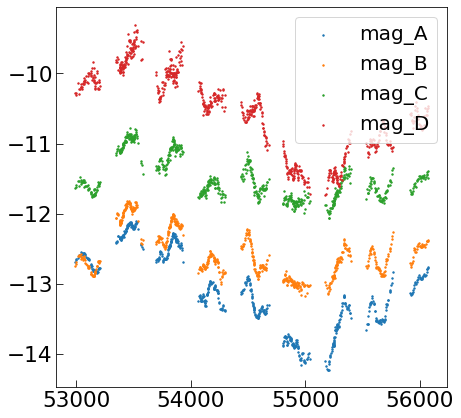

In [9]:
for mag in mag_columns:
  plt.scatter(data.mhjd, data[mag], s = 2, label = mag)
plt.legend(fontsize = 20)  

In [11]:
!pip install george

     |████████████████████████████████| 1.8MB 2.9MB/s 
     |████████████████████████████████| 153kB 52.8MB/s 
  ERROR: Failed building wheel for george
  Running setup.py clean for george
Failed to build george
    Running setup.py install for george ... done


In [0]:
from george import kernels

k1 = 66**2 * kernels.ExpSquaredKernel(metric=67**2)
k2 = 2.4**2 * kernels.ExpSquaredKernel(90**2) * kernels.ExpSine2Kernel(gamma=2/1.3**2, log_period=0.0)
k3 = 0.66**2 * kernels.RationalQuadraticKernel(log_alpha=np.log(0.78), metric=1.2**2)
k4 = 0.18**2 * kernels.ExpSquaredKernel(1.6**2)
kernel = k1 + k2 + k3 + k4

In [0]:
#Now let's try to model the time variability of the magnitude of the source A
t = data.mhjd.values
y = data.mag_A.values

In [14]:
import george
gp = george.GP(kernel, mean=np.mean(y), fit_mean=True,
               white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(t)
print("the current value of the log likelihood function = ", gp.log_likelihood(y))
print("the gradient of the log likelihood with respect to the parameters of the GP = ", gp.grad_log_likelihood(y))

the current value of the log likelihood function =  -573.8140964533761
the gradient of the log likelihood with respect to the parameters of the GP =  [-2.89970417e-04 -6.20522385e+01 -3.38224276e+01  9.47828601e+01
 -2.26666029e+01  7.94041919e+00 -2.35118401e+01 -5.23430285e+03
 -2.18572401e+02 -3.37974220e+01  6.44607550e+01 -1.58039353e+01
  4.56676723e+00]


Now let's optimize the likelihood function. 
Here we follow the script written by Dan Foreman Mackey in his nice tutorial:
[setting the hyper parameters](http://dfm.io/george/current/user/hyper/). 

Note however that a few lines need to change for the code to run:

(1) `gp.kernel[:] = p ` should be `gp.set_parameter_vector(p)`

(2) `p0 = gp.kernel.vector` should be `p0 = gp.get_parameter_vector()`

(3) `gp.kernel[:] = results.x` should be `gp.set_parameter_vector(results.x)`

After fixing these lines, the optimization script should work fine.

In [15]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-573.8140964533761
42.41960458419144


Note that the value of the log likelihood function rises significantly after the optimizations. As an excersize, check the gradients of the log likelihood with respect to the parameters to make sure that the optimization has properly converged. This can be a good sanity check!

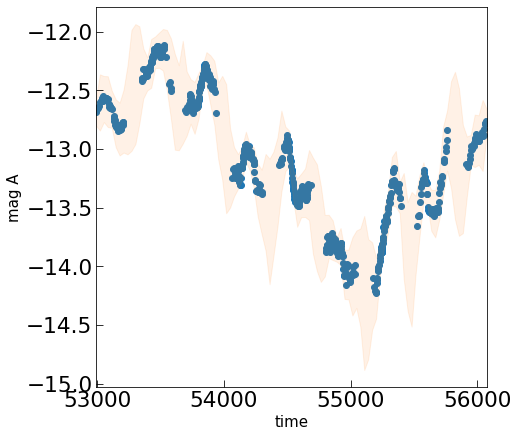

In [16]:
x = np.linspace(t.min(), t.max(), 100)
mu, var = gp.predict(y, x, return_var=True)
#print(mu, var)
std = np.sqrt(var)

plt.scatter(t, y)
plt.fill_between(x, mu+std, mu-std, color="C1", alpha=0.1)

plt.xlim(t.min(), t.max())
plt.xlabel("time")
plt.ylabel("mag A");

In [0]:
fb_ppm = pd.DataFrame(data.mag_A).reset_index()

In [18]:
data.mag_A.autocorr()

0.9963374541177071

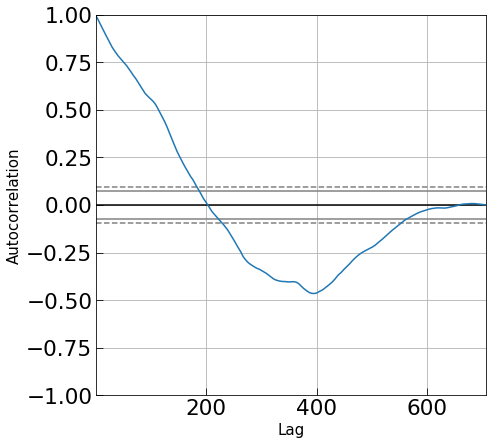

In [19]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data.mag_A)